# maysics.explain模块使用说明

explain模块包含十一个函数

|名称|作用|
|---|---|
|abs_error|绝对值列表|
|rel_error|相对误差列表|
|abs_sort|绝对误差从大到小的排序|
|rel_sort|相对误差从大到小的排序|
|sse|残差平方和|
|sae|绝对误差和|
|mse|平均平方误差|
|mae|平均绝对值误差|
|rmse|均方根误差|
|mape|平均绝对百分比误差|
|sense|灵敏度分析|

explain模块包含三个类

|名称|作用|
|---|---|
|Lime|局部代理|
|SHAP|SHAP值|
|Shapley|Shapley值|

<br></br>
## 误差分析：abs_error、rel_error、abs_sort、rel_sort、sse、sae、mse、mae、rmse、mape

f(func, data, target, param={})
<br>```func```：函数类型，模型的预测函数
<br>```data```：ndarray，自变量数据
<br>```target```一维ndarray，相应的因变量数据
<br>```param```：字典类型，当func有其他非默认参数时，需输入以参数名为键，参数值为值的字典

### DEMO 1-1：求数据集和函数$f(x)=2x$之间的各种误差

In [1]:
import maysics as ms
import numpy as np

def f(x):
    return 2 * x

np.random.seed(100)
data = np.arange(0, 5, 1)
target = data * 2 + np.random.rand(data.shape[0]) * 0.2 - 0.1

print('绝对值列表：', ms.explain.abs_error(f, data, target))
print('相对误差列表：', ms.explain.rel_error(f, data, target))
print('绝对误差从大到小的排序：', ms.explain.abs_sort(f, data, target))
print('相对误差从大到小的排序：', ms.explain.rel_sort(f, data, target))
print('残差平方和：', ms.explain.sse(f, data, target))
print('绝对误差和：', ms.explain.sae(f, data, target))
print('平均平方误差：', ms.explain.mse(f, data, target))
print('平均绝对值误差：', ms.explain.mae(f, data, target))
print('均方根误差：', ms.explain.rmse(f, data, target))
print('平均绝对百分比误差：', ms.explain.mape(f, data, target))

绝对值列表： [0.00868099 0.04432612 0.01509648 0.06895523 0.09905623]
相对误差列表： [1.         0.0226654  0.00378842 0.01136196 0.01253727]
绝对误差从大到小的排序： [(0.09905622876180509, 4), (0.06895522646398078, 3), (0.044326122981241056, 1), (0.015096481850173316, 2), (0.008680988358193087, 0)]
相对误差从大到小的排序： [(1.0, 0), (0.022665396057144287, 1), (0.012537265373587327, 4), (0.011361959989966327, 3), (0.0037884184099851296, 2)]
残差平方和： 0.016835028214885736
绝对误差和： 0.23611504841539332
平均平方误差： 0.0033670056429771474
平均绝对值误差： 0.047223009683078666
均方根误差： 0.05802590493027358
平均绝对百分比误差： 0.21007060796613666


### DEMO 1-2：用scipy.optimize.curvefit方法拟合数据并求得其平均平方误差mse

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import maysics as ms


def f(x, miu, sigma):
    return 1 / ((2 * np.pi)**0.5 * sigma) * np.e**(-(x - miu)**2 / (2 * sigma**2))

# 构造一个数据集
np.random.seed(100)
data = np.arange(-10, 10, 1)
target = f(data, 2, 1) + (np.random.random(20) - 0.5) * 0.05

result = curve_fit(f, data, target)[0]

print('拟合系数：', result)
print('mse：', ms.explain.mse(f, data, target, {'miu':result[0], 'sigma':result[1]}))

拟合系数： [1.96364438 1.04404433]
mse： 0.00022342810703901195


<br></br>
## 灵敏度分析：sense
sense(func, x0, acc=0.1, param={})
<br>```func```函数类型，模型的预测函数，若函数需要输入数组，则数组须为ndarray
<br>```x0```：数、一维或二维ndarray，与func的输入格式相同，特征的初始值
<br>```acc```：浮点数类型，求导精度
<br>```param```：字典类型，当func有其他非默认参数时，需输入以参数名为键，参数值为值的字典

### 原理
对函数$f(r)$，其中$r=(x_{0},x_{1},...,x_{n})$
<br>第i个特征在$r_{0}$处的灵敏度：$s(x_{i},r_{0})=\frac{dy}{dx_{i}}\frac{x_{i}}{y}$，$r=r_{0}$

### DEMO 2-1：求非批量输入函数$f(x,y)=x^{2}+y^{2}$在$(1,2)$处$x$和$y$的灵敏度

In [3]:
import maysics as ms

def f(x):
    return x[0]**2 + x[1]**2

ms.explain.sense(f, [1, 2])

array([0.38, 1.56])

### DEMO 2-2：求批量输入函数$f(x,y)=x^{2}+y^{2}$在${(1,2),(2,3)}$处$x$和$y$的灵敏度

In [4]:
import maysics as ms

def f(x):
    return x[:, 0]**2 + x[:, 1]**2

ms.explain.sense(f, [[1, 2], [2, 3]])

array([[0.38      , 1.56      ],
       [0.6       , 1.36153846]])

### DEMO 2-3：求有其他非默认参数的批量输入函数$𝑓(𝑥,𝑦)=𝑥^{2}+𝑦^{2}$在$(1,2),(2,3)$处$𝑥$和$𝑦$的灵敏度

In [5]:
import maysics as ms

def f(x, n1, n2):
    return x[:, 0]**n1 + x[:, 1]**n2

ms.explain.sense(f, [[1, 2], [2, 3]], param={'n1':2, 'n2':2})

array([[0.38      , 1.56      ],
       [0.6       , 1.36153846]])

<br></br>
## 局部代理：Lime
Lime(predict_f)
<br>```predict_f```：函数类型，模型的预测函数
<br>&emsp;当predict_f输出是一维的，则线性模型系数和模型各特征贡献都是一维的
<br>&emsp;当predict_f输出是一维的，则线性模型系数和模型各特征贡献都是二维的

### Lime的方法
Lime有三个方法：```fit```、```show```和```savefig```
<br>fit(data, acc=0.1, num=100, param={}, random_state=None)
<br>```data```：数组，局部点
<br>```acc```：浮点数类型，邻域范围
<br>```num```：整型，在领域抽样点的数量
<br>```param```：字典类型，当predict_f有其他非默认参数时，需输入以参数名为键，参数值为值的字典
<br>```random_state```：整型，随机种子

show(labels=None, index=None, top=None, estimate=None)
<br>savefig(filename, labels=None, index=None, top=None, estimate=None)
<br>```filename```：字符串类型，文件名
<br>```labels```：一维列表，特征名称
<br>```index```：一维列表，特征索引，默认全选
<br>```top```：整型，表示显示值最高的前top个特征，默认全选
<br>```estimate```：整型，表示图示示数保留的小数位数

### 原理
对局部点进行扰动并输入模型得到新的数据集
<br>以新数据集为基础，用最小二乘法拟合出新的线性模型$AX+b$用于局部代替黑盒模型
<br>利用该线性模型对黑盒模型进行解释
<br>预测值$=\Sigma weight + intercept$
<br>```fit```方法用于计算
<br>```show```和```savefig```用于绘图，前者显示，后者保存
<br>绘图方法仅适用于表格数据

### DEMO 3-1：求函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$附近的各特征指标

In [6]:
from maysics.explain import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([1, 0], random_state=100)

print('各个特征贡献：', lime.weight)
print('线性模型系数：', lime.coef)
print('线性模型截距：', lime.intercept)

各个特征贡献： [2.01479352 0.        ]
线性模型系数： [2.01479352 0.00945   ]
线性模型截距： -1.0080730843209873


### DEMO 3-2：求有其他非默认参数函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$附近的各特征指标

In [7]:
from maysics.explain import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x, n1, n2):
    x = np.array(x)
    return x[:, 0]**n1 + x[:, 1]**n2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([1, 0], param={'n1':2, 'n2':2}, random_state=100)

print('各个特征贡献：', lime.weight)
print('线性模型系数：', lime.coef)
print('线性模型截距：', lime.intercept)

各个特征贡献： [2.01479352 0.        ]
线性模型系数： [2.01479352 0.00945   ]
线性模型截距： -1.0080730843209873


### DEMO 3-3：用函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$附近的局部代理预测点$(1,0.1)$处的函数值

In [8]:
from maysics.explain import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([1, 0], random_state=100)

print('原模型：', f([[1, 0.1]]))
print('线性模型：', lime.predict([[1, 0.1]]))

原模型： [1.01]
线性模型： [1.00766544]


### DEMO 3-4：绘制函数$f(x,y)=x^{2}+y^{2}$在点$(2,1)$附近的各特征贡献值图

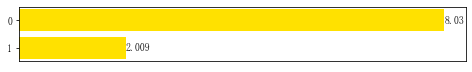

In [9]:
from maysics.explain import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([2, 1], random_state=100)

# 保留三位小数
lime.show(estimate=3)

### DEMO 3-5：绘制分类模型$f_{1}(x,y)=\frac{1}{1+e^{-x-y}}$，$f_{2}(x,y)=1-f_{1}(x,y)$在点$(-1,2)$附近的各特征贡献值图

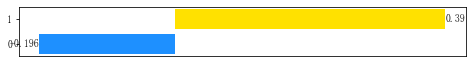

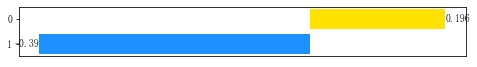

In [10]:
from maysics.explain import Lime
import numpy as np

def f(x):
    x = x[:, 0] + x[:, 1]
    x = 1 / (1 + np.e**(-x))
    return np.array([x, 1 - x]).T

lime = Lime(f)
lime.fit([-1, 2], random_state=100)
lime.show(estimate=3)

show函数和savefig函数仅支持表格数据的回归和分类模型的可视化

<br></br>
## SHAP值和Shapley值：SHAP和Shapley
SHAP(predict)
<br>Shapley(predict)
<br>```predict```：函数类型，模型的预测函数


### SHAP和Shapley的方法
两个类都有三个可调用方法：```fit```、```show```、```savefig```
<br>fit(data, replace=0, param={})
<br>```data```：二维数组，数据集
<br>```replace```：数或函数类型，特征的替换值，函数须以np.array(data)为输入
<br>```param```：字典类型，当predict有其他非默认参数时，需输入以参数名为键，参数值为值的字典

show(labels=None, index=None, top=None, estimate=None)
<br>savefig(filename, labels=None, index=None, top=None, estimate=None)
<br>```filename```：字符串类型，文件名
<br>```labels```：一维列表，特征名称
<br>```index```：一维列表，特征索引，默认全选
<br>```top```：整型，表示显示值最高的前top个特征，默认全选
<br>```estimate```：整型，表示图示示数保留的小数位数


### 功能说明
使用与Lime类似
<br>SHAP类和Shapley类仅适用于表格数据

### DEMO 4-1：求函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$的SHAP值

In [11]:
from maysics.explain import SHAP
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shap = SHAP(f)
shap.fit([1, 0])
shap.values

array([1., 0.])

### DEMO 4-2：绘制函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$的SHAP值

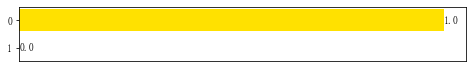

In [12]:
from maysics.explain import SHAP
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shap = SHAP(f)
shap.fit([1, 0])
shap.show()

### DEMO 4-3：求函数$f(x,y)=x^{2}+y^{2}$在点集${(1,0),(2,1)}$的Shapley值

In [13]:
from maysics.explain import Shapley
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shapley = Shapley(f)
shapley.fit([[1, 0], [2, 1]])
shapley.values

array([2.5, 0.5])

### DEMO 4-4：绘制函数$f(x,y)=x^{2}+y^{2}$在点集${(1,0),(2,1)}$的Shapley值

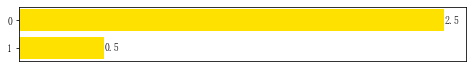

In [14]:
from maysics.explain import Shapley
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shapley = Shapley(f)
shapley.fit([[1, 0], [2, 1]])
shapley.show()

### DEMO 4-5：用SHAP值解决拼车车费问题
**问题阐述**
<br>现A、B、C三人需要共同拼车回家，已知A、B、C各自打车回家分别需要14.37、9.33、8.8，A、B拼车回家需要19.06，B、C拼车回家需要17.6，A、C拼车回家需要26.51，A、B、C共同拼车需要27.33，则A、B、C共同拼车分别应当承担多少车费？

<br>为了便于程序编辑，可以采用[1,0,0]代表A单独回家，[1,1,0]代表A、B拼车回家以此类推，并令[0,0,0]车费为0

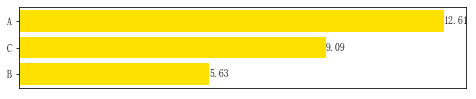

In [15]:
from maysics.explain import SHAP
import numpy as np
import math


# 生成相应的组合列表
def f(x):
    n = np.log(x + 1) / np.log(2)
    n = math.ceil(n)
    all_result = []
    for i in range(x+1):
        result = str(bin(i))[2:]
        num = len(result)
        if num < n:
            result = (n - num) * '0' + result
        result = list(map(int, result))
        all_result.append(result)
    return np.array(all_result)


# 定义车费函数
def g(x, cost_list):
    cost_list = np.array(cost_list)
    result = []
    union = f(2**(x.shape[1]) - 1)
    for i in x:
        for j in range(len(union)):
            if (i == union[j]).all():
                result.append(cost_list[j])
                break
    return np.array(result)


shap = SHAP(g)
shap.fit(np.array([1,1,1]),  # 将局部点设置在A、B、C共同拼车的位置
         param={'cost_list':[0, 8.8, 9.33, 17.6, 14.37, 26.51, 19.06, 27.33]})  # 传送g函数的其他参数
shap.show(labels=['A', 'B', 'C'], estimate=2) # 保留两位小数

因此A、B、C应当分别承担12.61、9.09、5.63

本模块中的以上两种解释方法：SHAP和Shapley，目前只能解释有一个预测值的回归模型